8. Reinf learning. Exercise: Use policy gradients to solve OpenAI Gym's LunarLander-v2 environment. You will need to install the Box2D dependencies (%pip install -U gym[box2d]). hands-on-ml book exerices page 623

In [1]:
import numpy as np
import gym
env = gym.make("LunarLander-v2")
obs = env.reset()
obs

array([-0.0057251 ,  1.4133191 , -0.57989806,  0.10661198,  0.00664065,
        0.13135552,  0.        ,  0.        ], dtype=float32)

In [2]:
import matplotlib.pyplot as plt
# img = env.render(mode="rgb_array")
# env.close()
# plt.imshow(img)
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(-inf, inf, (8,), float32)


In [3]:
# random policy
# print(np.mean(total_rewards), np.std(total_rewards), np.min(total_rewards), np.max(total_rewards))
# -179.8682271598708 113.57826569586982 -536.6091716341286 11.068357820341546

total_rewards = []
for i_episode in range(200):
    rewards = 0
    obs = env.reset()
    for t in range(200):
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        rewards += reward
        if done:
            break
    total_rewards.append(rewards)
print(np.mean(total_rewards), np.std(total_rewards), np.min(total_rewards), np.max(total_rewards))

-169.92407972827417 114.42740302485342 -635.8544079743916 35.9482687013184


In [4]:
# model

import tensorflow as tf
from tensorflow import keras

print(env.reset()[np.newaxis, :])
print(env.action_space.n)
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(env.observation_space.shape[0],)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(12, activation='relu'))
model.add(keras.layers.Dense(env.action_space.n, activation='softmax'))

model(env.reset()[np.newaxis, :])
print(model.trainable_variables)

/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resam

[[-1.1348724e-05  1.3984330e+00 -1.1662395e-03 -5.5498195e-01
   1.9964325e-05  2.6422073e-04  0.0000000e+00  0.0000000e+00]]
4
[<tf.Variable 'dense/kernel:0' shape=(8, 32) dtype=float32, numpy=
array([[ 0.2789963 ,  0.08988687,  0.16530448,  0.38207805,  0.2952683 ,
         0.14580142, -0.1053811 , -0.21996194, -0.34633228,  0.04505762,
         0.12492645,  0.31540477,  0.00900206, -0.22102772,  0.06412408,
        -0.37218946,  0.34160674, -0.29698238,  0.2313891 ,  0.34169775,
        -0.17452796, -0.06045508,  0.01905298, -0.30262643,  0.15100622,
        -0.3670276 ,  0.03495792,  0.22835463,  0.2387076 ,  0.3702411 ,
        -0.00675628,  0.24074471],
       [ 0.35841024, -0.10961273, -0.05431673,  0.27615982,  0.38315243,
        -0.18301392,  0.2678724 ,  0.08674726, -0.31620517, -0.2634016 ,
        -0.11574939,  0.37154955,  0.01541594,  0.2937876 ,  0.20555085,
         0.26670808,  0.12947124, -0.03203493,  0.1795047 ,  0.02346125,
         0.19778848, -0.18093094, -0.051

2022-05-25 16:53:08.502205: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# training
# approach from the book
# logits = tf.math.log(probas + keras.backend.epsilon())
# action = tf.random.categorical(logits, num_samples=1)
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        action_proba = model(obs[np.newaxis, :])[0]
        rand = tf.random.uniform([env.action_space.n]) # choose random action according to actions' probability
        actions = action_proba - rand
        max_action_value = tf.reduce_max(actions)
        action = int(tf.argmax(actions))
        y_target = tf.cast(actions == max_action_value, tf.float32) # right action is equal to 1 (action above) and 0s (not action) 
        # print(action_proba, y_target)
        loss = tf.reduce_mean(loss_fn(y_target, action_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, _ = env.step(action)
    return obs, reward, done, grads
play_one_step(env, env.reset(), model, keras.losses.categorical_crossentropy)

(array([-0.01114054,  1.420655  , -0.5589826 ,  0.20346141,  0.01134899,
         0.09707952,  0.        ,  0.        ], dtype=float32),
 0.7118944950623256,
 False,
 [<tf.Tensor: shape=(8, 32), dtype=float32, numpy=
  array([[-4.2052063e-05,  0.0000000e+00,  0.0000000e+00, -1.3758638e-03,
          -3.8100124e-04,  0.0000000e+00,  2.9844086e-04,  1.0833076e-03,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.8817047e-04,
          -2.2810367e-04,  2.0687671e-03,  1.0566426e-03, -2.0732637e-04,
          -3.8929511e-04,  1.0782813e-03,  0.0000000e+00, -1.8457569e-04,
           2.3759750e-04,  0.0000000e+00,  5.9741607e-04,  0.0000000e+00,
          -1.9600426e-03,  9.3876960e-04,  0.0000000e+00,  3.2559845e-05,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -3.7493880e-04],
         [ 1.0634146e-02,  0.0000000e+00,  0.0000000e+00,  3.4792912e-01,
           9.6347779e-02,  0.0000000e+00, -7.5469874e-02, -2.7394736e-01,
           0.0000000e+00,  0.0000000e+00, 

In [6]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor=0.97):
    discounted = np.array(rewards)
    for n_reward in range(len(discounted) - 2, -1, -1):
        discounted[n_reward] += discount_factor * discounted[n_reward + 1]
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor=0.97):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_all_discounted_rewards = np.concatenate(all_discounted_rewards)
    flat_mean = np.mean(flat_all_discounted_rewards)
    flat_std = np.std(flat_all_discounted_rewards)
    return [(discounted_rewards - flat_mean) / flat_std for discounted_rewards in all_discounted_rewards]

print(discount_rewards([10, 0, -50], 0.8)) # -22 -40 -50
print(discount_and_normalize_rewards([[10, 0, -50], [10, 20]], 0.8)) # -0.28 .... 1.26, 1.07

[-22 -40 -50]
[array([-0.28435071, -0.86597718, -1.18910299]), array([1.26665318, 1.0727777 ])]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [43:53<00:00,  8.78s/it]


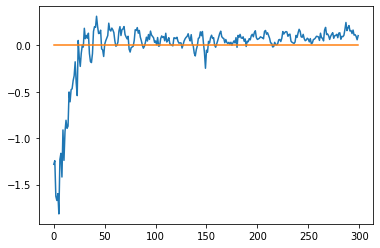

In [20]:
# training algorithm: play several episodes without applying grads, then apply mean grad according to a reward
from tqdm import tqdm
import matplotlib.pyplot as plt
import statistics

n_iterations = 300
n_episodes_per_update = 12
n_max_steps = 200
discount_factor = 0.95

optimizer = keras.optimizers.Adam(0.01)
loss_fn = keras.losses.categorical_crossentropy

def train():
    iteration_rewards = []
    final_iteration_rewards = []
    for n_iteration in tqdm(range(n_iterations)):
        all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
        # print(all_rewards)
        # print(statistics.mean(all_rewards))
        iteration_rewards.append(tf.reduce_mean(tf.ragged.constant(all_rewards)).numpy())
        final_iteration_rewards.append(tf.reduce_mean(tf.ragged.constant(all_final_rewards)).numpy())
        mean_grads = []
        for trainable_var_index in range(len(model.trainable_variables)):
            weighted_grads = []
            for episode, final_rewards in enumerate(all_final_rewards):
                for step, final_reward in enumerate(final_rewards):
                    grad = all_grads[episode][step][trainable_var_index]
                    weighted_grads.append(grad * final_reward) # the more reward the more grad is important
            mean_grad = tf.reduce_mean(weighted_grads, axis=0) # reduce mean to get a mean grad between all episodes and steps
            mean_grads.append(mean_grad)
        optimizer.apply_gradients(zip(mean_grads, model.trainable_variables))  
    return iteration_rewards, final_iteration_rewards
iteration_rewards, final_iteration_rewards = train()

plt.plot(iteration_rewards)
plt.plot(final_iteration_rewards)

In [21]:
# play with the trained model

total_rewards = []
for i_episode in tqdm(range(200)):
    rewards = 0
    obs = env.reset()
    for t in range(200):
        action_proba = model(obs[np.newaxis, :])[0]
        action = int(tf.argmax(action_proba))
        obs, reward, done, info = env.step(action)
        rewards += reward
        if done:
            break
    total_rewards.append(rewards)
# 29.660429310869976 24.329520575340702 -25.517524436082713 98.75970244131753
print(np.mean(total_rewards), np.std(total_rewards), np.min(total_rewards), np.max(total_rewards))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.06it/s]

14.460442828754037 22.81102173389233 -35.38405940311327 80.333859251291
